# US Road Accidents – Geospatial EDA


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point

# Optional: for optimization with large data
import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8")
sns.set_palette("viridis")

# 2. Display options
pd.set_option("display.max_columns", 100)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")


In [ ]:
DATA_PATH = '/content/drive/MyDrive/RoadSafety_Nov25/data/raw/US_Accidents_March23.csv'

# Load a sample if running locally with limited RAM
USE_SAMPLE = False
SAMPLE_FRAC = 0.1  # 10% sample

df = pd.read_csv(DATA_PATH)

if USE_SAMPLE:
    df = df.sample(frac=SAMPLE_FRAC, random_state=42).reset_index(drop=True)

df.shape, df.head()


((7728394, 46),
     ID   Source  Severity           Start_Time             End_Time  \
 0  A-1  Source2         3  2016-02-08 05:46:00  2016-02-08 11:00:00   
 1  A-2  Source2         2  2016-02-08 06:07:59  2016-02-08 06:37:59   
 2  A-3  Source2         2  2016-02-08 06:49:27  2016-02-08 07:19:27   
 3  A-4  Source2         3  2016-02-08 07:23:34  2016-02-08 07:53:34   
 4  A-5  Source2         2  2016-02-08 07:39:07  2016-02-08 08:09:07   
 
    Start_Lat  Start_Lng  End_Lat  End_Lng  Distance(mi)  \
 0    39.8651   -84.0587      NaN      NaN        0.0100   
 1    39.9281   -82.8312      NaN      NaN        0.0100   
 2    39.0631   -84.0326      NaN      NaN        0.0100   
 3    39.7478   -84.2056      NaN      NaN        0.0100   
 4    39.6278   -84.1884      NaN      NaN        0.0100   
 
                                          Description  \
 0  Right lane blocked due to accident on I-70 Eas...   
 1  Accident on Brice Rd at Tussing Rd. Expect del...   
 2  Accident on O

### Basic Overview and Geospatial Fields
- The dataset includes start latitude/longitude for each accident, plus state/city and other attributes

In [ ]:
df.info()
df.describe(include='all').T.head(20)

# Important geospatial & contextual columns (adjust depending on version)
geo_cols = [
    "ID", "Severity", "Start_Time", "End_Time",
    "Start_Lat", "Start_Lng", "End_Lat", "End_Lng",
    "City", "County", "State", "Zipcode"
]
[col for col in geo_cols if col in df.columns]

df[geo_cols].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object 
 11  Street                 object 
 12  City                   object 
 13  County                 object 
 14  State                  object 
 15  Zipcode                object 
 16  Country                object 
 17  Timezone               object 
 18  Airport_Code           object 
 19  Weather_Timestamp      object 
 20  Temperature(F)         float64
 21  Wind_Chill(F)          float64
 22  Humidity(%)       

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,City,County,State,Zipcode
0,A-1,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.8651,-84.0587,NaN,NaN,Dayton,Montgomery,OH,45424
1,A-2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.9281,-82.8312,NaN,NaN,Reynoldsburg,Franklin,OH,43068-3402
2,A-3,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.0631,-84.0326,NaN,NaN,Williamsburg,Clermont,OH,45176
3,A-4,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.7478,-84.2056,NaN,NaN,Dayton,Montgomery,OH,45417
4,A-5,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.6278,-84.1884,NaN,NaN,Dayton,Montgomery,OH,45459


- Check missingness focused on spatial fields.

In [ ]:
geo_subset = df[["Start_Lat", "Start_Lng", "City", "County", "State"]]
geo_subset.isna().mean().sort_values(ascending=False)

,0
City,0.0000
Start_Lat,0.0000
Start_Lng,0.0000
County,0.0000
State,0.0000


### Create GeoDataFrame
- Convert latitude/longitude into geometry points suitable for spatial analysis

In [ ]:
# Drop rows with missing start coordinates (core for spatial map)
df_geo = df.dropna(subset=['Start_Lat', 'Start_Lng']).copy()

# Create Shapely geometry
geometry = [Point(xy) for xy in zip(df_geo["Start_Lng"], df_geo['Start_Lat'])]

gdf = gpd.GeoDataFrame(
    df_geo,
    geometry = geometry,
    crs = "EPSG:4326"
)
gdf.head(), gdf.crs

(    ID   Source  Severity           Start_Time             End_Time  \
 0  A-1  Source2         3  2016-02-08 05:46:00  2016-02-08 11:00:00   
 1  A-2  Source2         2  2016-02-08 06:07:59  2016-02-08 06:37:59   
 2  A-3  Source2         2  2016-02-08 06:49:27  2016-02-08 07:19:27   
 3  A-4  Source2         3  2016-02-08 07:23:34  2016-02-08 07:53:34   
 4  A-5  Source2         2  2016-02-08 07:39:07  2016-02-08 08:09:07   
 
    Start_Lat  Start_Lng  End_Lat  End_Lng  Distance(mi)  \
 0    39.8651   -84.0587      NaN      NaN        0.0100   
 1    39.9281   -82.8312      NaN      NaN        0.0100   
 2    39.0631   -84.0326      NaN      NaN        0.0100   
 3    39.7478   -84.2056      NaN      NaN        0.0100   
 4    39.6278   -84.1884      NaN      NaN        0.0100   
 
                                          Description  \
 0  Right lane blocked due to accident on I-70 Eas...   
 1  Accident on Brice Rd at Tussing Rd. Expect del...   
 2  Accident on OH-32 State Route

- Optionally, reproject to a projected CRS for distance/area-based analysis.

In [ ]:
# Example: USA Contiguous Albers Equal Area projection
gdf_proj = gdf.to_crs(epsg=5070)
gdf_proj.crs

<Projected CRS: EPSG:5070>
Name: NAD83 / Conus Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: Conus Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### 5. Macro Spatial Distribution
 - Accidents by State and City

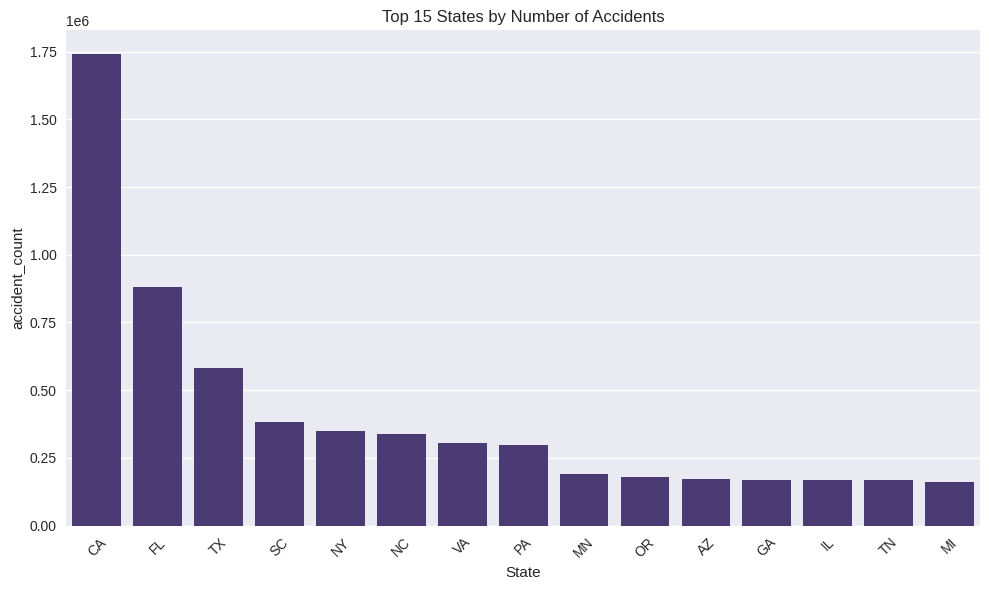

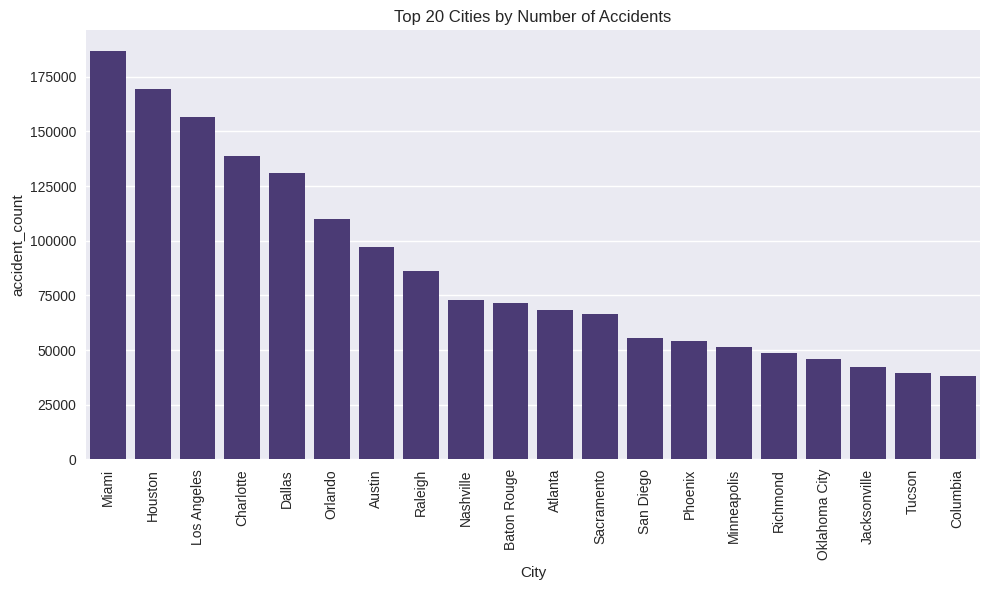

In [ ]:
# Accidents count by state
state_counts = gdf["State"].value_counts().reset_index()
state_counts.columns = ["State", "accident_count"]

plt.figure(figsize=(10, 6))
sns.barplot(data=state_counts.head(15), x="State", y="accident_count")
plt.title("Top 15 States by Number of Accidents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Accidents count by city
city_counts = gdf["City"].value_counts().reset_index()
city_counts.columns = ["City", "accident_count"]

plt.figure(figsize=(10, 6))
sns.barplot(data=city_counts.head(20), x="City", y="accident_count")
plt.title("Top 20 Cities by Number of Accidents")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 6. Static Geospatial Plots
- For dense data, sample points for plotting to avoid overplotting.

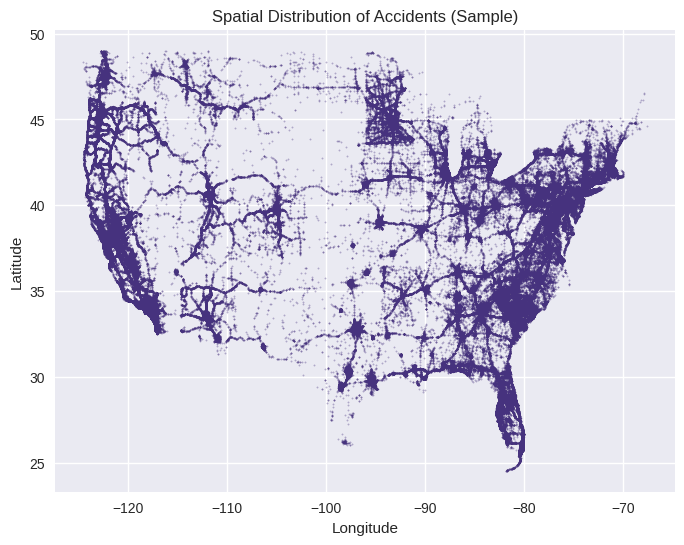

In [ ]:
# Sample for visualization
PLOT_SAMPLE = 1000_000
gdf_sample = gdf.sample(
    n=min(PLOT_SAMPLE, len(gdf)),
    random_state=42
)

# Scatter plot of accidents by coordinates
plt.figure(figsize=(8, 6))
plt.scatter(
    gdf_sample["Start_Lng"],
    gdf_sample["Start_Lat"],
    s=1,
    alpha=0.3
)
plt.title("Spatial Distribution of Accidents (Sample)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()